In [1]:
# $ mkdir -p ~/work/s2s_translation

In [2]:
!sudo apt update
!sudo apt-get install -y fonts-nanum
!pip install sentencepiece

Get:1 http://archive.ubuntu.com/ubuntu noble InRelease [256 kB]
Get:2 http://security.ubuntu.com/ubuntu noble-security InRelease [126 kB]
Get:3 http://archive.ubuntu.com/ubuntu noble-updates InRelease [126 kB]m
Get:4 http://security.ubuntu.com/ubuntu noble-security/universe amd64 Packages [1242 kB]
Get:5 http://archive.ubuntu.com/ubuntu noble-backports InRelease [126 kB]
Get:6 http://archive.ubuntu.com/ubuntu noble/restricted amd64 Packages [117 kB]
Get:7 http://archive.ubuntu.com/ubuntu noble/universe amd64 Packages [19.3 MB]
Get:8 http://security.ubuntu.com/ubuntu noble-security/main amd64 Packages [1883 kB]
Get:9 http://security.ubuntu.com/ubuntu noble-security/restricted amd64 Packages [3262 kB]
Get:10 http://security.ubuntu.com/ubuntu noble-security/multiverse amd64 Packages [34.8 kB]
Get:11 http://archive.ubuntu.com/ubuntu noble/multiverse amd64 Packages [331 kB]
Get:12 http://archive.ubuntu.com/ubuntu noble/main amd64 Packages [1808 kB]
Get:13 http://archive.ubuntu.com/ubuntu no

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import logging

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

fontpath = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
fontprop = fm.FontProperties(fname=fontpath, size=12)
plt.rcParams["font.family"] = fontprop.get_name()

print(f"설정된 폰트: {fontprop.get_name()}")

설정된 폰트: NanumBarunGothic


## 2. 데이터 전처리
### 데이터 준비하기

In [4]:
import os
import re
import urllib.request
import zipfile
import sentencepiece as spm
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)

2.7.1+cu118


In [5]:
dataset_dir = os.path.expanduser("work/s2s_translation/datasets")
os.makedirs(dataset_dir, exist_ok=True)

zip_path = os.path.join(dataset_dir, "spa-eng.zip")

if not os.path.exists(zip_path):
    print("데이터 다운로드 중...")
    url = "http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
    urllib.request.urlretrieve(url, zip_path)
    print("다운로드 완료!")

data_folder = os.path.join(dataset_dir, "spa-eng")
if not os.path.exists(data_folder):
    print("압축 해제 중...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)
    print("압축 해제 완료!")

path_to_file = os.path.join(data_folder, "spa.txt")

print("데이터셋 디렉토리:", os.listdir(dataset_dir))

데이터 다운로드 중...
다운로드 완료!
압축 해제 중...
압축 해제 완료!
데이터셋 디렉토리: ['spa-eng', 'spa-eng.zip']


In [6]:
df = pd.read_csv(path_to_file, sep = "\t", names = ["eng", "spa"])
df.head()

,eng,spa
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


### 데이터 전처리: 정제하기

In [7]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    return sentence

print("슝~")

슝~


In [8]:
df = df[:30000]

df["eng"] = df["eng"].apply(preprocess_sentence)
df["spa"] = df["spa"].apply(lambda x: preprocess_sentence(x))

df.head()

,eng,spa
0,go .,ve .
1,go .,vete .
2,go .,vaya .
3,go .,v yase .
4,hi .,hola .


### 데이터 전처리: 토큰화

In [9]:
df["eng"].to_csv("eng_corpus.txt", index=False, header=False, sep="\n", encoding="utf-8")
df["spa"].to_csv("spa_corpus.txt", index=False, header=False, sep="\n", encoding="utf-8")

print("파일 저장 완료: eng_corpus.txt, spa_corpus.txt")

파일 저장 완료: eng_corpus.txt, spa_corpus.txt


In [10]:
vocab_size = 3000
pad_id = 0
bos_id = 1
eos_id = 2
unk_id = 3

spm.SentencePieceTrainer.train(
    input = "eng_corpus.txt",
    model_prefix = "encoder_spm",
    vocab_size = vocab_size,
    pad_id = pad_id,
    bos_id = bos_id,
    eos_id = eos_id,
    unk_id = unk_id
)

spm.SentencePieceTrainer.train(
    input = "spa_corpus.txt",
    model_prefix = "decoder_spm",
    vocab_size = vocab_size,
    pad_id = pad_id,
    bos_id = bos_id,
    eos_id = eos_id,
    unk_id = unk_id
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: eng_corpus.txt
  input_format: 
  model_prefix: encoder_spm
  model_type: UNIGRAM
  vocab_size: 3000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  d

In [11]:
encoder_tokenizer = spm.SentencePieceProcessor()
encoder_tokenizer.load("encoder_spm.model")

decoder_tokenizer = spm.SentencePieceProcessor()
decoder_tokenizer.load("decoder_spm.model")

True

In [12]:
df

,eng,spa
0,go .,ve .
1,go .,vete .
2,go .,vaya .
3,go .,v yase .
4,hi .,hola .
...,...,...
29995,we ll go after we eat .,iremos despu s de comer .
29996,we ll live like kings .,viviremos como reyes .
29997,we ll lose everything .,lo perderemos todo .
29998,we ll meet right here .,nos encontraremos aqu mismo .


In [13]:
eng_sample = df["eng"][10000]
spa_sample = df["spa"][10000]
print(eng_sample)
print(spa_sample)

do you like fish ?
te gusta el pescado ?


In [14]:
enc_token = encoder_tokenizer.encode(eng_sample)
enc_token = [encoder_tokenizer.bos_id()] + enc_token + [encoder_tokenizer.eos_id()]
enc_token

[1, 27, 7, 39, 324, 9, 2]

In [15]:
enc_decoding = encoder_tokenizer.decode(enc_token)
enc_decoding

'do you like fish ?'

In [16]:
class TranslationDataset(Dataset):
    def __init__(self, data, encoder_tokenizer, decoder_tokenizer, max_len):
        self.data = data
        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer
        self.max_len = max_len
        self.pad_id = 0
        self.bos_id = 1
        self.eos_id = 2

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src_text = self.data.iloc[idx]['eng']
        trg_text = self.data.iloc[idx]['spa']

        src_ids = self.encoder_tokenizer.encode(src_text)
        trg_ids = self.decoder_tokenizer.encode(trg_text)

        src_ids = src_ids[:self.max_len]

        # Decoder의 입력에는 START_TOKEN과 END_TOKEN을 추가해줍니다. 단, 최대 길이 제한을 적용시킵니다.
        trg_input = [self.bos_id] + trg_ids[:self.max_len - 2] + [self.eos_id]
        trg_label = trg_ids[:self.max_len - 1] + [self.eos_id]

        # 길이가 짧은 경우 PAD_TOKEN을 추가해줍니다.
        src_ids = src_ids + [self.pad_id] * (self.max_len - len(src_ids))
        trg_input = trg_input + [self.pad_id] * (self.max_len - len(trg_input))
        trg_label = trg_label + [self.pad_id] * (self.max_len - len(trg_label))

        return torch.tensor(src_ids), torch.tensor(trg_input), torch.tensor(trg_label)

In [17]:
train_ratio = 0.8  # 전체 길이의 80%
MAX_LEN = 30 # 임의의 값
BATCH_SIZE = 64

train_data = df.sample(frac=train_ratio, random_state=42)  # 80% 훈련 데이터
valid_data = df.drop(train_data.index)

train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

train_data = TranslationDataset(train_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)
validation_data = TranslationDataset(valid_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
for src, trg_input, trg_label in train_loader:
    print(src.shape, trg_input.shape, trg_label.shape)
    break

torch.Size([64, 30]) torch.Size([64, 30]) torch.Size([64, 30])


### 3. 모델 설계

In [19]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: (batch_size, hidden_dim)
        # encoder_outputs: (src_len, batch_size, hidden_dim)

        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # (batch_size, src_len, hidden_dim)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # (batch_size, src_len, hidden_dim)

        energy = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden))  # (batch_size, src_len, hidden_dim)
        attention = self.v(energy).squeeze(2)  # (batch_size, src_len)

        return nn.functional.softmax(attention, dim=1)  # (batch_size, src_len)

In [20]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim)

    def forward(self, src):
        # src : (src_len, batch_size)
        embedded = self.embedding(src)  # embedded : (src_len, batch_size, emb_dim)
        outputs, hidden = self.rnn(embedded)  # outputs : (src_len, batch_size, hidden_dim)

        return outputs, hidden

In [21]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, attention):
        super(Decoder, self).__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        # Decoder RNN에는 embedding만 입력
        self.rnn = nn.GRU(emb_dim, hidden_dim)
        # 출력층에는 hidden state와 attention value가 결합되어 입력
        self.fc_out = nn.Linear(hidden_dim + hidden_dim, output_dim)

    def forward(self, input, hidden, encoder_outputs):
        # input : (batch_size,)
        # hidden : (batch_size, hidden_dim)
        # encoder_outputs : (src_len, batch_size, hidden_dim)
        input = input.unsqueeze(0)  # input : (1, batch_size)
        embedded = self.embedding(input)  # embedded : (1, batch_size, emb_dim)

        # attention distribution을 계산합니다. decoder의 이전 hidden state, s_{t-1}와 encoder의 H가 입력됩니다.
        a = self.attention(hidden[-1], encoder_outputs)  # a : (batch_size, src_len)

        # H에 가중치를 부여해 attention value(Context vector) 계산
        a = a.unsqueeze(1)  # a : (batch_size, 1, src_len)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # encoder_outputs : (batch_size, src_len, hidden_dim)
        context = torch.bmm(a, encoder_outputs)  # context : (batch_size, 1, hidden_dim)
        context = context.permute(1, 0, 2)  # context : (1, batch_size, hidden_dim)

        output, hidden = self.rnn(embedded, hidden)

        # 출력층에서는 현재 hidden state와 context vector를 결합하여 예측값 생성
        output = output.squeeze(0)  # output : (batch_size, hidden_dim)
        context = context.squeeze(0)  # context : (batch_size, hidden_dim)
        prediction = self.fc_out(torch.cat((output, context), dim=1))  # (batch_size, output_dim)

        return prediction, hidden, a.squeeze(1)

In [22]:
class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg=None, max_len=30, bos_id = 1, eos_id=2):
        # 학습 모드에서는 trg_len 사용, 추론 모드에서는 max_len까지 동적 생성
        batch_size = src.shape[1]
        trg_vocab_size = self.decoder.fc_out.out_features

        # 조기 종료를 위해 tensor가 아닌 리스트 사용
        outputs = []

        # 시각화를 위해 attention 저장
        attentions = []

        # 인코더를 통해 context 생성
        encoder_outputs, hidden = self.encoder(src)

        if trg is not None:
            for t in range(0, trg.shape[0]):
                input = trg[t]
                output, hidden, attention = self.decoder(input, hidden, encoder_outputs)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))

        else:
		    # inference에서는 target(정답)이 없기 때문에 sos_token을 생성해줍니다.
            input = torch.full((batch_size,), bos_id, dtype=torch.long, device=self.device)
            finished = torch.zeros(batch_size, dtype=torch.bool, device=self.device)

            for t in range(max_len):
                output, hidden, attention = self.decoder(input, hidden,  encoder_outputs)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))
                top1 = output.argmax(1)
                input = top1

                # 조기 종료 조건
                finished |= (top1 == eos_id)
                if finished.all():
                    break

        outputs = torch.cat(outputs, dim=0)  # (trg_len, batch_size, output_dim)
        attentions = torch.cat(attentions, dim=0)  # (trg_len, batch_size, src_len)

        return outputs, attentions

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = len(encoder_tokenizer)
output_dim = len(decoder_tokenizer)
emb_dim = 256
hid_dim = 512

In [24]:
encoder = Encoder(input_dim, emb_dim, hid_dim).to(device)
attention = BahdanauAttention(hid_dim).to(device)
decoder = Decoder(output_dim, emb_dim, hid_dim, attention).to(device)
model = Seq2SeqAttention(encoder, decoder, device).to(device)

In [25]:
print(model)

Seq2SeqAttention(
  (encoder): Encoder(
    (embedding): Embedding(3000, 256)
    (rnn): GRU(256, 512)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (W1): Linear(in_features=512, out_features=512, bias=True)
      (W2): Linear(in_features=512, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(3000, 256)
    (rnn): GRU(256, 512)
    (fc_out): Linear(in_features=1024, out_features=3000, bias=True)
  )
)


### 4. 훈련하기

### (1) Optimizer & Loss

In [26]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)

print("슝~")

슝~


### (2) train_step 구현하기

In [27]:
def train_step(model, data_loader, optimizer, criterion, epoch):
    model.train()
    epoch_loss = 0

    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}", leave=True)

    for src, trg_input, trg_label in progress_bar:
        # 모델의 입력 순서에 맞게 transpose 변환
        src = src.permute(1, 0).to(device)
        trg_input = trg_input.permute(1, 0).to(device)
        trg_label = trg_label.permute(1, 0).to(device)
        optimizer.zero_grad()

        outputs,_ = model(src, trg_input)
        
        # (trg_len, batch_size, output_dim)을 (batch_size * trg_len, output_dim)으로 변환
        outputs = outputs.reshape(-1, outputs.shape[-1])
        trg_label = trg_label.reshape(-1)

        loss = criterion(outputs, trg_label)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        epoch_loss += loss.item()

        progress_bar.set_postfix(loss=loss.item())

    return epoch_loss / len(data_loader)

print("슝~")


슝~


### (3) 훈련 시작하기

In [29]:
%%time

EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss = train_step(model, train_loader, optimizer, criterion, epoch)
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}')

Epoch 1: 100%|██████████| 375/375 [00:40<00:00,  9.35it/s, loss=2.09]


Epoch 1/10, Train Loss: 3.0601


Epoch 2: 100%|██████████| 375/375 [00:39<00:00,  9.38it/s, loss=1.36]


Epoch 2/10, Train Loss: 1.5214


Epoch 3: 100%|██████████| 375/375 [00:39<00:00,  9.52it/s, loss=0.8]  


Epoch 3/10, Train Loss: 0.9253


Epoch 4: 100%|██████████| 375/375 [00:39<00:00,  9.41it/s, loss=0.69] 


Epoch 4/10, Train Loss: 0.5934


Epoch 5: 100%|██████████| 375/375 [00:39<00:00,  9.50it/s, loss=0.419]


Epoch 5/10, Train Loss: 0.3995


Epoch 6: 100%|██████████| 375/375 [00:39<00:00,  9.46it/s, loss=0.389]


Epoch 6/10, Train Loss: 0.2951


Epoch 7: 100%|██████████| 375/375 [00:39<00:00,  9.47it/s, loss=0.22] 


Epoch 7/10, Train Loss: 0.2435


Epoch 8: 100%|██████████| 375/375 [00:39<00:00,  9.50it/s, loss=0.216]


Epoch 8/10, Train Loss: 0.2191


Epoch 9: 100%|██████████| 375/375 [00:39<00:00,  9.46it/s, loss=0.25] 


Epoch 9/10, Train Loss: 0.2096


Epoch 10: 100%|██████████| 375/375 [00:39<00:00,  9.48it/s, loss=0.206] 

Epoch 10/10, Train Loss: 0.2031
CPU times: user 6min 35s, sys: 4.95 s, total: 6min 40s
Wall time: 6min 36s


In [30]:
def eval_step(model, data_loader, optimizer, criterion):
    model.eval()
    total_loss = 0

    for src, trg_input, trg_label in data_loader:
        # 모델의 입력 순서에 맞게 transpose 변환
        src = src.permute(1, 0).to(device)
        trg_input = trg_input.permute(1, 0).to(device)
        trg_label = trg_label.permute(1, 0).to(device)

        outputs,_ = model(src, trg_input)
        
        # (trg_len, batch_size, output_dim)을 (batch_size * trg_len, output_dim)으로 변환
        outputs = outputs.reshape(-1, outputs.shape[-1])
        trg_label = trg_label.reshape(-1)

        loss = criterion(outputs, trg_label)

        total_loss += loss.item()

    return total_loss / len(data_loader)

print("슝~")

슝~


In [31]:
%%time

EPOCHS = 20

for epoch in range(EPOCHS):
    train_loss = train_step(model, train_loader, optimizer, criterion, epoch)
    valid_loss = eval_step(model, validation_loader, optimizer, criterion)
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

Epoch 1: 100%|██████████| 375/375 [00:41<00:00,  9.14it/s, loss=0.202]


Epoch 1/20, Train Loss: 0.2013, Validation Loss: 1.7554


Epoch 2: 100%|██████████| 375/375 [00:39<00:00,  9.61it/s, loss=0.266] 


Epoch 2/20, Train Loss: 0.1977, Validation Loss: 1.7774


Epoch 3: 100%|██████████| 375/375 [00:39<00:00,  9.45it/s, loss=0.174]


Epoch 3/20, Train Loss: 0.1965, Validation Loss: 1.7925


Epoch 4: 100%|██████████| 375/375 [00:39<00:00,  9.50it/s, loss=0.206]


Epoch 4/20, Train Loss: 0.1944, Validation Loss: 1.8252


Epoch 5: 100%|██████████| 375/375 [00:39<00:00,  9.47it/s, loss=0.183] 


Epoch 5/20, Train Loss: 0.1968, Validation Loss: 1.8439


Epoch 6: 100%|██████████| 375/375 [00:39<00:00,  9.49it/s, loss=0.264] 


Epoch 6/20, Train Loss: 0.1935, Validation Loss: 1.8546


Epoch 7: 100%|██████████| 375/375 [00:39<00:00,  9.52it/s, loss=0.249] 


Epoch 7/20, Train Loss: 0.1925, Validation Loss: 1.8564


Epoch 8: 100%|██████████| 375/375 [00:39<00:00,  9.52it/s, loss=0.228] 


Epoch 8/20, Train Loss: 0.1915, Validation Loss: 1.8728


Epoch 9: 100%|██████████| 375/375 [00:39<00:00,  9.52it/s, loss=0.177] 


Epoch 9/20, Train Loss: 0.1891, Validation Loss: 1.8968


Epoch 10: 100%|██████████| 375/375 [00:39<00:00,  9.50it/s, loss=0.187] 


Epoch 10/20, Train Loss: 0.1861, Validation Loss: 1.9231


Epoch 11: 100%|██████████| 375/375 [00:39<00:00,  9.50it/s, loss=0.225] 


Epoch 11/20, Train Loss: 0.1835, Validation Loss: 1.8981


Epoch 12: 100%|██████████| 375/375 [00:39<00:00,  9.52it/s, loss=0.243]


Epoch 12/20, Train Loss: 0.1845, Validation Loss: 1.9248


Epoch 13: 100%|██████████| 375/375 [00:39<00:00,  9.50it/s, loss=0.22]  


Epoch 13/20, Train Loss: 0.1817, Validation Loss: 1.9167


Epoch 14: 100%|██████████| 375/375 [00:39<00:00,  9.51it/s, loss=0.218] 


Epoch 14/20, Train Loss: 0.1802, Validation Loss: 1.9312


Epoch 15: 100%|██████████| 375/375 [00:39<00:00,  9.53it/s, loss=0.236] 


Epoch 15/20, Train Loss: 0.1764, Validation Loss: 1.9189


Epoch 16: 100%|██████████| 375/375 [00:39<00:00,  9.54it/s, loss=0.17]  


Epoch 16/20, Train Loss: 0.1761, Validation Loss: 1.9473


Epoch 17: 100%|██████████| 375/375 [00:39<00:00,  9.54it/s, loss=0.3]   


Epoch 17/20, Train Loss: 0.1724, Validation Loss: 1.9454


Epoch 18: 100%|██████████| 375/375 [00:39<00:00,  9.53it/s, loss=0.188] 


Epoch 18/20, Train Loss: 0.1732, Validation Loss: 1.9507


Epoch 19: 100%|██████████| 375/375 [00:39<00:00,  9.52it/s, loss=0.241] 


Epoch 19/20, Train Loss: 0.1722, Validation Loss: 1.9667


Epoch 20: 100%|██████████| 375/375 [00:39<00:00,  9.49it/s, loss=0.155] 


Epoch 20/20, Train Loss: 0.1714, Validation Loss: 1.9575
CPU times: user 14min 21s, sys: 9.25 s, total: 14min 31s
Wall time: 14min 23s


In [32]:
def evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=30):
    model.eval()

    sentence = preprocess_sentence(sentence)
    src_ids = encoder_tokenizer.encode(sentence)
    src_ids = src_ids[:max_len]
    src_ids = src_ids + [0] * (max_len - len(src_ids))  # 패딩 추가
    src_tensor = torch.tensor(src_ids).unsqueeze(1).to(device)  # (src_len, 1)

    with torch.no_grad():
        outputs, attentions = model(src_tensor, max_len=max_len)

    result = [decoder_tokenizer.decode([token.item()]) for token in outputs.argmax(2).squeeze(1)]

    if "<end>" in result:
        result = result[:result.index("<end>")]

    return result, sentence, attentions.squeeze(1).cpu().numpy()

In [33]:
def plot_attention(attention, sentence, predicted_sentence):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticks(range(len(sentence)))
    ax.set_xticklabels(sentence, fontdict=fontdict, rotation=90)

    ax.set_yticks(range(len(predicted_sentence)))
    ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

    plt.show()

In [34]:
def translate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=30):
    result, sentence, attention = evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    # Attention 크기 조정 (trg_len, src_len)
    attention = attention[:len(result), :len(sentence.split())]

    plot_attention(attention, sentence.split(), result)

Input: the most powerful man all over the world .
Predicted translation: ['el', 'perro', 'de', 'todo', 's', 'ello', 's', 't', 'l', 'to', '.', '']


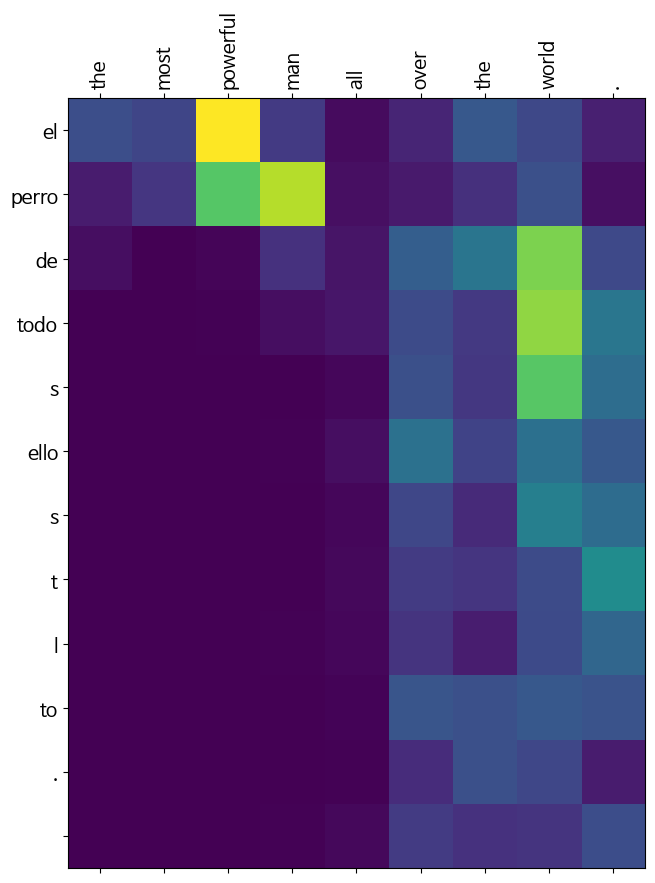

In [35]:
translate("The most powerful man all over the world.", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

Input: may i help you ?
Predicted translation: ['pued', 'o', 'ayudar', 'te', '?', '']


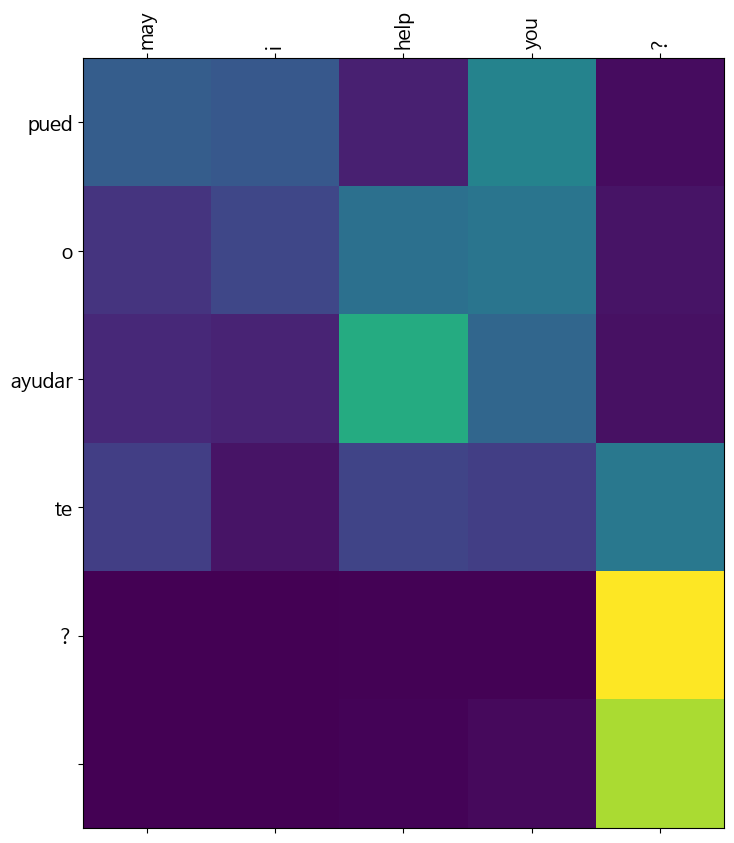

In [36]:
translate("May I help you?", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

Input: can i have some coffee ?
Predicted translation: ['pued', 'o', 'tomar', 'algo', 'de', 'c', 'af', '?', '']


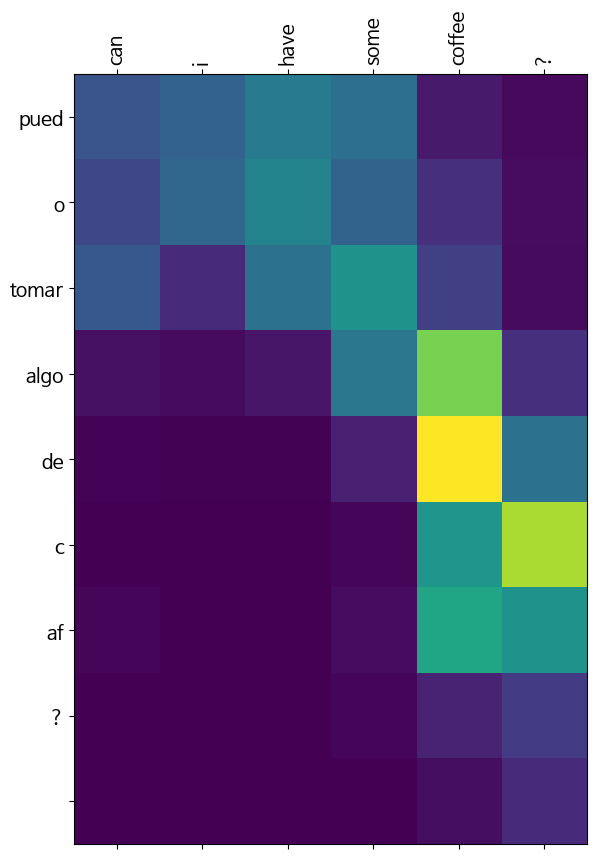

In [37]:
# 실행 예제
translate("Can I have some coffee?", model, encoder_tokenizer, decoder_tokenizer, max_len=30)